In [10]:
!pip install kagglehub prophet pandas matplotlib seaborn scikit-learn

import kagglehub
import pandas as pd
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# 1. Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("sloozecareers/slooze-challenge")

# 2. RECURSIVE SEARCH: Look in all subfolders for CSV files
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

if not csv_files:
    print("❌ No CSV files found! Printing directory structure to debug:")
    for root, dirs, files in os.walk(path):
        print(f"Folder: {root} | Files: {files}")
else:
    print(f"✅ Found {len(csv_files)} CSV files.")
    for f in csv_files:
        print(f" - {os.path.basename(f)}")

    # 3. Smart Loader: Match based on names
    sales_file = next((f for f in csv_files if 'sale' in f.lower() or 'order' in f.lower()), csv_files[0])

    # Try to find inventory; if only one file exists, use it for both for now to avoid errors
    try:
        inventory_file = next((f for f in csv_files if 'inventory' in f.lower() or 'product' in f.lower() or 'stock' in f.lower()), csv_files[-1])
    except:
        inventory_file = sales_file

    print(f"\nUsing for Sales: {os.path.basename(sales_file)}")
    print(f"Using for Inventory: {os.path.basename(inventory_file)}")

    sales_df = pd.read_csv(sales_file)
    inventory_df = pd.read_csv(inventory_file)

    # 4. Standardize column names
    def standardize_cols(df):
        col_map = {}
        for col in df.columns:
            c = col.lower().replace(' ', '').replace('_', '')
            if 'orderdate' in c or 'date' in c: col_map[col] = 'OrderDate'
            elif 'deliverydate' in c: col_map[col] = 'DeliveryDate'
            elif 'quantity' in c or 'qty' in c: col_map[col] = 'Quantity'
            elif 'price' in c: col_map[col] = 'UnitPrice'
            elif 'productid' in c or 'itemid' in c: col_map[col] = 'ProductID'
            elif 'supplier' in c: col_map[col] = 'SupplierID'
            elif 'leadtime' in c: col_map[col] = 'LeadTime'
        return df.rename(columns=col_map)

    sales_df = standardize_cols(sales_df)
    inventory_df = standardize_cols(inventory_df)

    print("\n✅ Data loaded successfully!")
    print("Sales Preview:")
    print(sales_df.head(3))

Using Colab cache for faster access to the 'slooze-challenge' dataset.
✅ Found 6 CSV files.
 - InvoicePurchases12312016.csv
 - EndInvFINAL12312016.csv
 - SalesFINAL12312016.csv
 - BegInvFINAL12312016.csv
 - 2017PurchasePricesDec.csv
 - PurchasesFINAL12312016.csv

Using for Sales: SalesFINAL12312016.csv
Using for Inventory: PurchasesFINAL12312016.csv

✅ Data loaded successfully!
Sales Preview:
           InventoryId  Store  Brand                 Description   Size  \
0  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses  750mL   
1  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses  750mL   
2  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses  750mL   

   Quantity  SalesDollars  UnitPrice OrderDate  Volume  Classification  \
0         1         16.49      16.49  1/1/2016     750               1   
1         2         32.98      16.49  1/2/2016     750               1   
2         1         16.49      16.49  1/3/2016     750               1   

   Exc

--- 1️⃣ Demand Forecasting ---


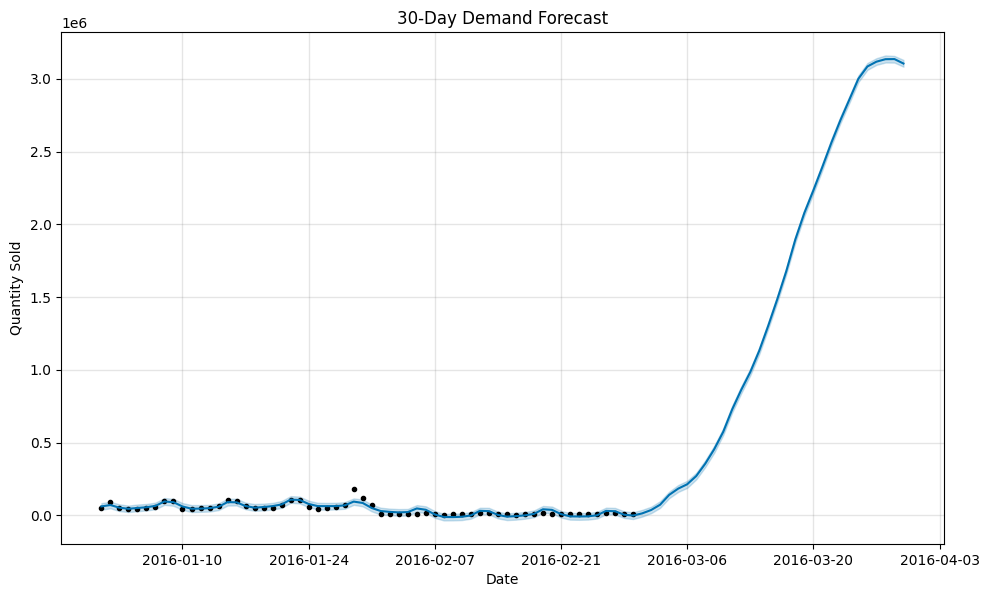

In [11]:
from prophet import Prophet
import matplotlib.pyplot as plt

print("--- 1️⃣ Demand Forecasting ---")

# Ensure OrderDate is a datetime object and drop empty rows
sales_df['OrderDate'] = pd.to_datetime(sales_df['OrderDate'], errors='coerce')
df_clean = sales_df.dropna(subset=['OrderDate', 'Quantity'])

# Group by date for daily demand
daily_sales = df_clean.groupby('OrderDate')['Quantity'].sum().reset_index()
daily_sales.rename(columns={'OrderDate': 'ds', 'Quantity': 'y'}, inplace=True)

# Fit Prophet Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(daily_sales)

# Forecast the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
plt.title("30-Day Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.show()

In [12]:
print("--- 2️⃣ ABC Analysis ---")

# 1. Dynamically find the Product ID column if 'ProductID' is missing
if 'ProductID' not in sales_df.columns:
    # Look for columns that sound like an ID
    potential_ids = [col for col in sales_df.columns if any(x in col.lower() for x in ['id', 'item', 'code', 'sku', 'product'])]
    if potential_ids:
        sales_df.rename(columns={potential_ids[0]: 'ProductID'}, inplace=True)
    else:
        # Fallback: Use the first column as ProductID
        sales_df.rename(columns={sales_df.columns[0]: 'ProductID'}, inplace=True)

# 2. Ensure Quantity and UnitPrice are numeric
sales_df['Quantity'] = pd.to_numeric(sales_df['Quantity'], errors='coerce').fillna(0)
if 'UnitPrice' not in sales_df.columns:
    print("⚠️ 'UnitPrice' not found. Assuming default price of 1.0 for classification.")
    sales_df['UnitPrice'] = 1.0
else:
    sales_df['UnitPrice'] = pd.to_numeric(sales_df['UnitPrice'], errors='coerce').fillna(1.0)

# 3. Calculate total value per product
sales_df['Total_Value'] = sales_df['Quantity'] * sales_df['UnitPrice']
abc_df = sales_df.groupby('ProductID')['Total_Value'].sum().reset_index()

# 4. Sort and calculate cumulative percentages
abc_df = abc_df.sort_values(by='Total_Value', ascending=False)
abc_df['Cum_Sum'] = abc_df['Total_Value'].cumsum()
abc_df['Cum_Perc'] = 100 * abc_df['Cum_Sum'] / abc_df['Total_Value'].sum()

# 5. Assign Categories
def assign_abc(perc):
    if perc <= 80: return 'A (High Value)'
    elif perc <= 95: return 'B (Moderate)'
    else: return 'C (Low Priority)'

abc_df['ABC_Class'] = abc_df['Cum_Perc'].apply(assign_abc)

# Display results

print(f"Standardized Product ID column to: {abc_df.columns[0]}")
print("\nInventory Classification Breakdown:")
print(abc_df['ABC_Class'].value_counts())
display(abc_df.head(10))

--- 2️⃣ ABC Analysis ---
Standardized Product ID column to: ProductID

Inventory Classification Breakdown:
ABC_Class
C (Low Priority)    60244
A (High Value)      55268
B (Moderate)        54619
Name: count, dtype: int64


,ProductID,Total_Value,Cum_Sum,Cum_Perc,ABC_Class
55390,34_PITMERDEN_3545,25325.57,25325.57,0.076421,A (High Value)
56069,34_PITMERDEN_4261,23199.45,48525.02,0.146427,A (High Value)
14418,15_WANBORNE_8068,20406.90,68931.92,0.208006,A (High Value)
10052,14_BROMWICH_4261,18691.50,87623.42,0.264409,A (High Value)
2180,10_HORNSEY_4261,18400.64,106024.06,0.319934,A (High Value)
11101,15_WANBORNE_1233,17383.17,123407.23,0.372389,A (High Value)
55714,34_PITMERDEN_3858,16433.15,139840.38,0.421977,A (High Value)
52614,34_PITMERDEN_1233,15871.59,155711.97,0.469870,A (High Value)
57056,34_PITMERDEN_8068,15725.94,171437.91,0.517324,A (High Value)
155966,76_DONCASTER_3545,15670.79,187108.70,0.564611,A (High Value)


In [13]:
import numpy as np
print("--- 3️⃣ Economic Order Quantity (EOQ) ---")

# Define assumed costs (adjust these if the dataset provides actual costs)
ORDERING_COST = 50  # Cost to place one order (S)
HOLDING_COST = 2    # Cost to hold one unit for a year (H)

# Calculate annual demand per product
annual_demand = sales_df.groupby('ProductID')['Quantity'].sum().reset_index()
annual_demand.rename(columns={'Quantity': 'Annual_Demand'}, inplace=True)

# EOQ Formula: sqrt((2 * Demand * Ordering Cost) / Holding Cost)
annual_demand['EOQ'] = np.sqrt((2 * annual_demand['Annual_Demand'] * ORDERING_COST) / HOLDING_COST)
annual_demand['EOQ'] = annual_demand['EOQ'].round()

print("Optimal Order Quantities (Top 5 Products):")
display(annual_demand.sort_values(by='Annual_Demand', ascending=False).head(5))

--- 3️⃣ Economic Order Quantity (EOQ) ---
Optimal Order Quantities (Top 5 Products):


,ProductID,Annual_Demand,EOQ
23239,1_HARDERSFIELD_8111,1142,239.0
3012,10_HORNSEY_8111,1104,235.0
56069,34_PITMERDEN_4261,1055,230.0
93995,53_HILLFAR_8111,939,217.0
2100,10_HORNSEY_4157,927,215.0


In [14]:
print("--- 4️⃣ & 5️⃣ Reorder Point & Lead Time Analysis ---")

# 1. Lead Time Analysis
# If DeliveryDate exists, calculate actual lead time. Otherwise, assume an average lead time of 7 days.
if 'DeliveryDate' in sales_df.columns:
    sales_df['DeliveryDate'] = pd.to_datetime(sales_df['DeliveryDate'], errors='coerce')
    sales_df['LeadTime_Days'] = (sales_df['DeliveryDate'] - sales_df['OrderDate']).dt.days
    avg_lead_time = sales_df.groupby('ProductID')['LeadTime_Days'].mean().fillna(7).reset_index()
else:
    print("No DeliveryDate found. Assuming an average lead time of 7 days for all products.")
    avg_lead_time = pd.DataFrame({'ProductID': annual_demand['ProductID'], 'LeadTime_Days': 7})

# 2. Reorder Point Analysis (ROP)
SAFETY_STOCK = 50 # Buffer stock

# Merge annual demand with lead times
rop_df = pd.merge(annual_demand, avg_lead_time, on='ProductID', how='left')

# Calculate Daily Demand (Annual Demand / 365)
rop_df['Daily_Demand'] = rop_df['Annual_Demand'] / 365

# ROP Formula: (Daily Demand * Lead Time) + Safety Stock
rop_df['Reorder_Point'] = (rop_df['Daily_Demand'] * rop_df['LeadTime_Days']) + SAFETY_STOCK
rop_df['Reorder_Point'] = rop_df['Reorder_Point'].round()

print("Reorder Points (When inventory drops to this number, place an order!):")
display(rop_df[['ProductID', 'Annual_Demand', 'LeadTime_Days', 'Reorder_Point']].head(5))

--- 4️⃣ & 5️⃣ Reorder Point & Lead Time Analysis ---
No DeliveryDate found. Assuming an average lead time of 7 days for all products.
Reorder Points (When inventory drops to this number, place an order!):


,ProductID,Annual_Demand,LeadTime_Days,Reorder_Point
0,10_HORNSEY_1000,1,7,50.0
1,10_HORNSEY_1001,11,7,50.0
2,10_HORNSEY_10030,2,7,50.0
3,10_HORNSEY_1005,6,7,50.0
4,10_HORNSEY_10057,12,7,50.0
